# NIH Seizure Prediction using Bayesian Lasso Logistic Regression and Pymc3


Code and documentation for my solution (52th place) for the Kaggle Melbourne University AES/MathWorks/NIH Seizure Prediction challenge : https://www.kaggle.com/solomonk

### A 2016 Kaggle competition.

https://www.kaggle.com/c/melbourne-university-seizure-prediction

This notebbok was reviwed by https://github.com/fonnesbeck. Changes made by Chris include: 

    Used NUTS with ADVI initialization
    Reparameterized to include an intercept
    Rescaled (normalized) the predictors
    Used Lasso regression to eliminate some of the variables, as several were almost perfectly correlated.
    
### For Lasso regression refer to: 

Tibshirani (1996), "Regression Shrinkage and Selection via the Lasso"
Note the name "lasso" is  an acronym for:  Least Absolute Selection and Shrinkage Operator

The only difference between the lasso problem and ridge regression is that the latter uses a (squared L2) penalty while the former uses an L1 penalty.  

    http://yaroslavvb.com/papers/genkin-large.pdf
    https://rpubs.com/ryankelly/reg

In [1]:
%reset -f
%matplotlib inline

# DEFINE THE RESPONSE VARIABLE FOR THIS DATA SET
singleResponseVariable = 'result'

INTERICTAL = 0
PREICTAL = 1
        
## Assigning data types to attributes:
from datetime import datetime
import numpy
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
dirToInclude=parentdir +'/features/'
sys.path.insert(0,dirToInclude)

import IeegConsts
from IeegConsts import *
from IeegFeatures import *

import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt

import theano.tensor as tt

%matplotlib inline

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)
    
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train_dir=TRAIN_DATA_FOLDER_IN_ALL
test_dir=TEST_DATA_FOLDER_IN_ALL    


ieegFeatures= IeegFeatures(train_dir, True)
df_cols_train=ieegFeatures.ieegGenCols()
print(len(df_cols_train))
X_df_train= pd.read_hdf('data/output/feat_train/train_allX_df_train.hdf', 'data',format='fixed',complib='blosc',complevel=9)

# X_df_train.drop('Unnamed: 0', axis=1, inplace=True)


Starting:ieegFeatures:2017-02-13 11:48:09.072331
Cols:1239
1239


# Select features

In [2]:
n=16
last_cols=list()
for i in range(1, n_psd + 1):
    last_cols.append('psd_{}'.format(i))    
for i in range(1, 16 + 1):
    last_cols.append('var_{}'.format(i))    
for i in range(1, 16 + 1):
    last_cols.append('kurt_{}'.format(i))
for i in range(1, n_corr_coeff + 1):
    last_cols.append('corcoef_{}'.format(i))
for i in range(1, n + 1):
    last_cols.append('hurst_{}'.format(i))
# for i in range(1,  n_plv+ 1):
#     last_cols.append('plv_{}'.format(i))    
# for i in range(1, n + 1):
#     last_cols.append('mean_{}'.format(i))
# for i in range(1, n + 1):
#     last_cols.append('median_{}'.format(i))
# for i in range(1, n + 1):
#     last_cols.append('std_{}'.format(i))

X_df_train_SINGLE=X_df_train


X_df_train_SINGLE.drop('id', axis=1, inplace=True)
X_df_train_SINGLE.drop('file', axis=1, inplace=True)
X_df_train_SINGLE.drop('patient_id', axis=1, inplace=True)

X_df_train_SINGLE = X_df_train_SINGLE.loc[X_df_train_SINGLE['file_size'] > 100000]
X_df_train_SINGLE.drop('file_size', axis=1, inplace=True)
X_df_train_SINGLE.drop('sequence_id', axis=1, inplace=True)
X_df_train_SINGLE.drop('segment', axis=1, inplace=True)

answers_1_SINGLE = list (X_df_train_SINGLE[singleResponseVariable].values)
X_df_train_SINGLE = X_df_train_SINGLE.drop(singleResponseVariable, axis=1)

X_df_train_SINGLE=X_df_train_SINGLE[last_cols]
X_df_train_SINGLE=X_df_train_SINGLE.apply(lambda x: pandas.to_numeric(x, errors='ignore'))
X_df_train_SINGLE.head(5)

,psd_1,psd_2,psd_3,psd_4,psd_5,psd_6,psd_7,psd_8,psd_9,psd_10,psd_11,psd_12,psd_13,psd_14,psd_15,psd_16,psd_17,psd_18,psd_19,psd_20,psd_21,psd_22,psd_23,psd_24,psd_25,psd_26,psd_27,psd_28,psd_29,psd_30,psd_31,psd_32,psd_33,psd_34,psd_35,psd_36,psd_37,psd_38,psd_39,psd_40,psd_41,psd_42,psd_43,psd_44,psd_45,psd_46,psd_47,psd_48,psd_49,psd_50,psd_51,psd_52,psd_53,psd_54,psd_55,psd_56,psd_57,psd_58,psd_59,psd_60,psd_61,psd_62,psd_63,psd_64,psd_65,psd_66,psd_67,psd_68,psd_69,psd_70,psd_71,psd_72,psd_73,psd_74,psd_75,psd_76,psd_77,psd_78,psd_79,psd_80,psd_81,psd_82,psd_83,psd_84,psd_85,psd_86,psd_87,psd_88,psd_89,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99,psd_100,psd_101,psd_102,psd_103,psd_104,psd_105,psd_106,psd_107,psd_108,psd_109,psd_110,psd_111,psd_112,psd_113,psd_114,psd_115,psd_116,psd_117,psd_118,psd_119,psd_120,psd_121,psd_122,psd_123,psd_124,psd_125,psd_126,psd_127,psd_128,psd_129,psd_130,psd_131,psd_132,psd_133,psd_134,psd_135,psd_136,psd_137,psd_138,psd_139,psd_140,psd_141,psd_142,psd_143,psd_144,psd_145,psd_146,psd_147,psd_148,psd_149,psd_150,psd_151,psd_152,psd_153,psd_154,psd_155,psd_156,psd_157,psd_158,psd_159,psd_160,psd_161,psd_162,psd_163,psd_164,psd_165,psd_166,psd_167,psd_168,psd_169,psd_170,psd_171,psd_172,psd_173,psd_174,psd_175,psd_176,psd_177,psd_178,psd_179,psd_180,psd_181,psd_182,psd_183,psd_184,psd_185,psd_186,psd_187,psd_188,psd_189,psd_190,psd_191,psd_192,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,kurt_1,kurt_2,kurt_3,kurt_4,kurt_5,kurt_6,kurt_7,kurt_8,kurt_9,kurt_10,kurt_11,kurt_12,kurt_13,kurt_14,kurt_15,kurt_16,corcoef_1,corcoef_2,corcoef_3,corcoef_4,corcoef_5,corcoef_6,corcoef_7,corcoef_8,corcoef_9,corcoef_10,corcoef_11,corcoef_12,corcoef_13,corcoef_14,corcoef_15,corcoef_16,corcoef_17,corcoef_18,corcoef_19,corcoef_20,corcoef_21,corcoef_22,corcoef_23,corcoef_24,corcoef_25,corcoef_26,corcoef_27,corcoef_28,corcoef_29,corcoef_30,corcoef_31,corcoef_32,corcoef_33,corcoef_34,corcoef_35,corcoef_36,corcoef_37,corcoef_38,corcoef_39,corcoef_40,corcoef_41,corcoef_42,corcoef_43,corcoef_44,corcoef_45,corcoef_46,corcoef_47,corcoef_48,corcoef_49,corcoef_50,corcoef_51,corcoef_52,corcoef_53,corcoef_54,corcoef_55,corcoef_56,corcoef_57,corcoef_58,corcoef_59,corcoef_60,corcoef_61,corcoef_62,corcoef_63,corcoef_64,corcoef_65,corcoef_66,corcoef_67,corcoef_68,corcoef_69,corcoef_70,corcoef_71,corcoef_72,corcoef_73,corcoef_74,corcoef_75,corcoef_76,corcoef_77,corcoef_78,corcoef_79,corcoef_80,corcoef_81,corcoef_82,corcoef_83,corcoef_84,corcoef_85,corcoef_86,corcoef_87,corcoef_88,corcoef_89,corcoef_90,corcoef_91,corcoef_92,corcoef_93,corcoef_94,corcoef_95,corcoef_96,corcoef_97,corcoef_98,corcoef_99,corcoef_100,corcoef_101,corcoef_102,corcoef_103,corcoef_104,corcoef_105,corcoef_106,corcoef_107,corcoef_108,corcoef_109,corcoef_110,corcoef_111,corcoef_112,corcoef_113,corcoef_114,corcoef_115,corcoef_116,corcoef_117,corcoef_118,corcoef_119,corcoef_120,hurst_1,hurst_2,hurst_3,hurst_4,hurst_5,hurst_6,hurst_7,hurst_8,hurst_9,hurst_10,hurst_11,hurst_12,hurst_13,hurst_14,hurst_15,hurst_16
0,-0.406786,-0.506428,-0.550631,-0.602230,-0.117925,-0.258156,-0.292530,-0.310629,-0.464966,-2.681048,-0.672553,-0.735941,-0.558759,-0.644890,-0.688039,-0.669862,-0.510144,-0.598658,-0.646677,-0.670835,-0.129998,-0.251415,-0.323000,-0.227784,-0.639318,-2.760449,-0.665167,-0.659974,-0.590483,-0.588708,-0.647818,-0.715215,-0.629282,-0.647044,-0.621452,-0.675702,-0.426132,-0.442531,-0.483979,-0.434602,-0.750417,-2.766089,-0.708479,-0.729438,-0.629134,-0.464072,-0.620423,-0.708196,-0.707625,-0.711356,-0.642788,-0.672846,-0.478605,-0.479591,-0.520513,-0.456928,-0.790443,-2.769022,-0.732106,-0.730806,-0.646176,-0.473156,-0.634019,-0.703660,-0.763965,-0.765547,-0.680584,-0.695172,-0.550166,-0.547159,-0.539212,-0.476176,-0.818632,-2.770506,-0.785050,-0.764124,-0.638319,-0.486804,-0.654367,-0.688834,-0.905803,-0.866233,-0.841806,-0.849490,-0.760451,-0.696508,-0.704839,-0.673899,

## Normalize data (added by Chris)

In [ ]:
k = (X_df_train_SINGLE.shape[1])
y=answers_1_SINGLE
X=X_df_train_SINGLE
# Normalize variables 
X_norm = (X - X.mean())/X.std() 

# Define the model in PyMC3

In [5]:
%%latex

UsageError: %%latex is a cell magic, but the cell body is empty.


In [3]:
with pm.Model() as logistic_model:        
    u = pm.Normal('u', 0, sd=10)
    b = pm.Laplace('b', 0.0, b=0.1, shape=k)    
    p = pm.math.invlogit(u + tt.dot(X_norm, b))    
    likelihood = pm.Bernoulli('likelihood', p, observed=y)

# Run the model

In [4]:
niter=2000
with logistic_model:
    trace_logistic_model = pm.sample(niter, n_init=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -8,542.1: 100%|██████████| 50000/50000 [04:21<00:00, 191.41it/s]
Finished [100%]: Average ELBO = -7,611
100%|██████████| 2000/2000 [1:46:14<00:00,  1.56s/it]  


# Visualize the coeefs

In [19]:
# predict
# last_cols=X_df_train_SINGLE.columns
updated_cols=list()
updated_cols.append('Intercept')
for i in range(1, n_psd + 1):
    updated_cols.append('psd_{}'.format(i))    
for i in range(1, 16 + 1):
    updated_cols.append('var_{}'.format(i))    
for i in range(1, 16 + 1):
    updated_cols.append('kurt_{}'.format(i))
for i in range(1, n_corr_coeff + 1):
    updated_cols.append('corcoef_{}'.format(i))
for i in range(1, n + 1):
    updated_cols.append('hurst_{}'.format(i))

df_trace_logistic_model = pm.trace_to_dataframe(trace_logistic_model[niter//2:])
df_trace_logistic_model.columns=updated_cols
w_theta = df_trace_logistic_model[updated_cols].mean(0)
df_trace_logistic_model.to_csv("df_trace_logistic_model.csv")
w_theta.to_csv("w_theta.csv")
w_intercept=df_trace_logistic_model['Intercept'].mean(0)
print w_intercept
# pm.summary(trace_logistic_model[-1000:])

-0.055806363955


In [14]:
df_trace_logistic_model.head(5)

,Intercept,psd_1,psd_2,psd_3,psd_4,psd_5,psd_6,psd_7,psd_8,psd_9,psd_10,psd_11,psd_12,psd_13,psd_14,psd_15,psd_16,psd_17,psd_18,psd_19,psd_20,psd_21,psd_22,psd_23,psd_24,psd_25,psd_26,psd_27,psd_28,psd_29,psd_30,psd_31,psd_32,psd_33,psd_34,psd_35,psd_36,psd_37,psd_38,psd_39,psd_40,psd_41,psd_42,psd_43,psd_44,psd_45,psd_46,psd_47,psd_48,psd_49,psd_50,psd_51,psd_52,psd_53,psd_54,psd_55,psd_56,psd_57,psd_58,psd_59,psd_60,psd_61,psd_62,psd_63,psd_64,psd_65,psd_66,psd_67,psd_68,psd_69,psd_70,psd_71,psd_72,psd_73,psd_74,psd_75,psd_76,psd_77,psd_78,psd_79,psd_80,psd_81,psd_82,psd_83,psd_84,psd_85,psd_86,psd_87,psd_88,psd_89,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99,psd_100,psd_101,psd_102,psd_103,psd_104,psd_105,psd_106,psd_107,psd_108,psd_109,psd_110,psd_111,psd_112,psd_113,psd_114,psd_115,psd_116,psd_117,psd_118,psd_119,psd_120,psd_121,psd_122,psd_123,psd_124,psd_125,psd_126,psd_127,psd_128,psd_129,psd_130,psd_131,psd_132,psd_133,psd_134,psd_135,psd_136,psd_137,psd_138,psd_139,psd_140,psd_141,psd_142,psd_143,psd_144,psd_145,psd_146,psd_147,psd_148,psd_149,psd_150,psd_151,psd_152,psd_153,psd_154,psd_155,psd_156,psd_157,psd_158,psd_159,psd_160,psd_161,psd_162,psd_163,psd_164,psd_165,psd_166,psd_167,psd_168,psd_169,psd_170,psd_171,psd_172,psd_173,psd_174,psd_175,psd_176,psd_177,psd_178,psd_179,psd_180,psd_181,psd_182,psd_183,psd_184,psd_185,psd_186,psd_187,psd_188,psd_189,psd_190,psd_191,psd_192,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,kurt_1,kurt_2,kurt_3,kurt_4,kurt_5,kurt_6,kurt_7,kurt_8,kurt_9,kurt_10,kurt_11,kurt_12,kurt_13,kurt_14,kurt_15,kurt_16,corcoef_1,corcoef_2,corcoef_3,corcoef_4,corcoef_5,corcoef_6,corcoef_7,corcoef_8,corcoef_9,corcoef_10,corcoef_11,corcoef_12,corcoef_13,corcoef_14,corcoef_15,corcoef_16,corcoef_17,corcoef_18,corcoef_19,corcoef_20,corcoef_21,corcoef_22,corcoef_23,corcoef_24,corcoef_25,corcoef_26,corcoef_27,corcoef_28,corcoef_29,corcoef_30,corcoef_31,corcoef_32,corcoef_33,corcoef_34,corcoef_35,corcoef_36,corcoef_37,corcoef_38,corcoef_39,corcoef_40,corcoef_41,corcoef_42,corcoef_43,corcoef_44,corcoef_45,corcoef_46,corcoef_47,corcoef_48,corcoef_49,corcoef_50,corcoef_51,corcoef_52,corcoef_53,corcoef_54,corcoef_55,corcoef_56,corcoef_57,corcoef_58,corcoef_59,corcoef_60,corcoef_61,corcoef_62,corcoef_63,corcoef_64,corcoef_65,corcoef_66,corcoef_67,corcoef_68,corcoef_69,corcoef_70,corcoef_71,corcoef_72,corcoef_73,corcoef_74,corcoef_75,corcoef_76,corcoef_77,corcoef_78,corcoef_79,corcoef_80,corcoef_81,corcoef_82,corcoef_83,corcoef_84,corcoef_85,corcoef_86,corcoef_87,corcoef_88,corcoef_89,corcoef_90,corcoef_91,corcoef_92,corcoef_93,corcoef_94,corcoef_95,corcoef_96,corcoef_97,corcoef_98,corcoef_99,corcoef_100,corcoef_101,corcoef_102,corcoef_103,corcoef_104,corcoef_105,corcoef_106,corcoef_107,corcoef_108,corcoef_109,corcoef_110,corcoef_111,corcoef_112,corcoef_113,corcoef_114,corcoef_115,corcoef_116,corcoef_117,corcoef_118,corcoef_119,corcoef_120,hurst_1,hurst_2,hurst_3,hurst_4,hurst_5,hurst_6,hurst_7,hurst_8,hurst_9,hurst_10,hurst_11,hurst_12,hurst_13,hurst_14,hurst_15,hurst_16
0,-0.072390,-0.245047,-0.099863,0.436660,-0.082723,-0.018296,-0.173525,-0.281135,-0.207588,0.051031,0.100164,0.071931,-0.096843,0.078650,-0.105942,0.022549,0.020536,0.047192,-0.020923,0.022251,0.034800,-0.115753,-0.287135,-0.440424,0.015382,0.087452,0.104714,0.011891,-0.086032,-0.017618,-0.067408,0.060414,0.054331,0.136665,-0.000872,-0.030140,0.082472,0.110731,0.216410,0.006930,0.148332,-0.030381,-0.011871,-0.143428,-0.075077,0.006232,-0.070464,0.043215,0.006354,-0.08856,-0.182434,-0.091762,0.350864,-0.003938,0.021481,0.092337,0.208354,0.219567,-0.082901,0.034864,0.097162,-0.000987,-0.050503,-0.360810,0.036868,0.192198,-0.234516,-0.450690,0.171335,-0.108969,0.053924,0.060658,0.060414,-0.012302,-0.050390,0.103290,-0.431556,0.029801,0.107098,-0.215955,0.096309,0.177630,0.022937,-0.070277,-0.013544,0.095770,0.089496,0.275689,-0.237480,-0.024417,0.638436,0.157640,

# Run trace

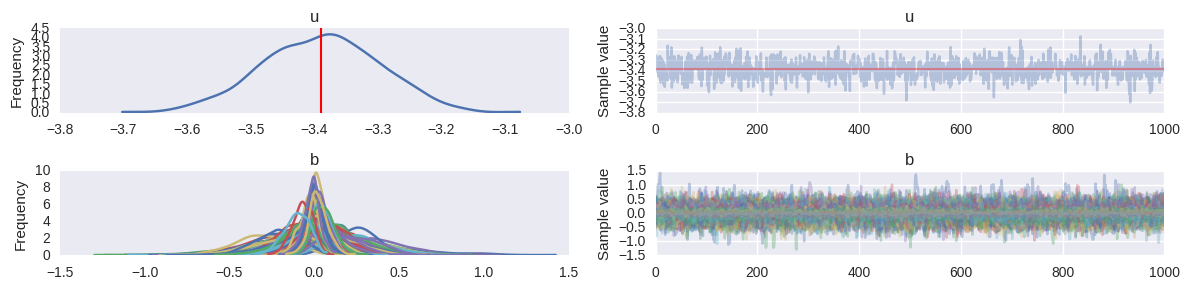

In [15]:
ax = pm.traceplot(trace_logistic_model[-1000:], figsize=(12,len(trace_logistic_model.varnames)*1.5),  
    lines={k: v['mean'] for k, v in pm.df_summary(trace_logistic_model[-1000:]).iterrows()})

# Use the model to predict on the test data set

## Define the prediction function

In [34]:
from scipy.special import expit

# Theta includes an Intercept term which was added by Chris, so we have to adjust for it here
def fastPredict(new_observation, theta):     
    v =  np.einsum('j,j->',new_observation, theta[1:theta.size])    
    return expit(v)


## Make predictions and create a submission file

In [35]:
# --------------------------------------------------------
    #       PATIENT ID
    # --------------------------------------------------------
def getIdFromFileName(id_str):
    arr = id_str.split("_")
#     print arr
    patient = int(arr[1])
#     print patient
    p_id_str = str(arr[2])
#     print p_id_str
    p_id = int((p_id_str)[:-4])
#     print p_id
    new_id = [patient * 100000 + p_id]
    return new_id
    

test_dir=TEST_DATA_FOLDER_IN_ALL
ieegFeatures= IeegFeatures(test_dir, False)
df_cols_test=ieegFeatures.ieegGenCols()
print len(df_cols_test)
F_NAME_TEST= 'data/output/feat_test/test_all-feat_TEST_df.csv'
X_df_TEST=pandas.read_csv(F_NAME_TEST, engine='python') 
X_df_TEST.drop('Unnamed: 0', axis=1, inplace=True)
# X_df_TEST.drop('id', axis=1, inplace=True)
X_df_TEST.drop('file', axis=1, inplace=True)
X_df_TEST.drop('patient_id', axis=1, inplace=True)
# X_df_TEST.drop('file_size', axis=1, inplace=True)
# X_df_TEST.drop('sequence_id', axis=1, inplace=True)
X_df_TEST.head(3)

#------------------------------------------------------------------------------#
now = datetime.now()
import dis
sub_file = 'submission' + '_mcmc_' + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'

r= pandas.DataFrame.from_csv('data/sample_submission.csv')
print('Writing submission: ', sub_file)
f = open(sub_file, 'w') # append mode
f.write('File,Class\n')
total = 0

for index, row in r.iterrows():            
    id_str= index     
    arr = id_str.split("_")
#     print str(arr)
#     print str(arr[0])
#     print str(arr[1])
#     print str(arr[2])
    patient = int(arr[1])        
    new_id= getIdFromFileName(id_str) 
#     print str(new_id)
    
    X_df_single_row=X_df_TEST.loc[X_df_TEST['id'] == new_id]
    X_df_single_row.drop('id', axis=1, inplace=True)
    X_df_single_row= X_df_single_row[last_cols]        
#     X_df_single_row.drop('file', axis=1, inplace=True)
#     X_df_single_row.drop('patient_id', axis=1, inplace=True)                    
    X_df_single_row = np.asarray(X_df_single_row) 
#     print str(X_df_single_row.size)
#     print str(w_theta.size)
    c_pred= 1.0- fastPredict( (tuple (X_df_single_row)[0]), w_theta)
    str1 = id_str + ',' + str(c_pred) + '\n'  
#     print str1
    
    f.write(str1)
    
f.close()

print('Done writing submission: ', sub_file)

Starting:ieegFeatures:2017-02-13 14:09:35.832882
Cols:1235
1235
('Writing submission: ', 'submission_mcmc_2017-02-13-14-09.csv')
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361
360
361